# Analyzing the NYC Restaurant Inspections Dataset using Topic Modeling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# ingest data into DataFrame
filenames = ["DOHMH_New_York_City_Restaurant_Inspection_Results_"+str(i)+"_of_6.txt" for i in range(1,7)]
df = pd.concat((pd.read_csv(f) for f in filenames))

In [3]:
# number of records
len(df)

399918

In [4]:
# available columns
df.columns

Index(['Unnamed: 0', 'CAMIS', 'DBA', 'BORO', 'BUILDING', 'STREET', 'ZIPCODE',
       'PHONE', 'CUISINE DESCRIPTION', 'INSPECTION DATE', 'ACTION',
       'VIOLATION CODE', 'VIOLATION DESCRIPTION', 'CRITICAL FLAG', 'SCORE',
       'GRADE', 'GRADE DATE', 'RECORD DATE', 'INSPECTION TYPE'],
      dtype='object')

## Exploratory Data Analysis

In [5]:
# grade values in the dataset
df['GRADE'].unique()

array([nan, 'C', 'A', 'B', 'Z', 'Not Yet Graded', 'P'], dtype=object)

In [6]:
# remove restaurants without grade
dfgr = df.dropna(subset=['GRADE'])

### Look at grades by boro

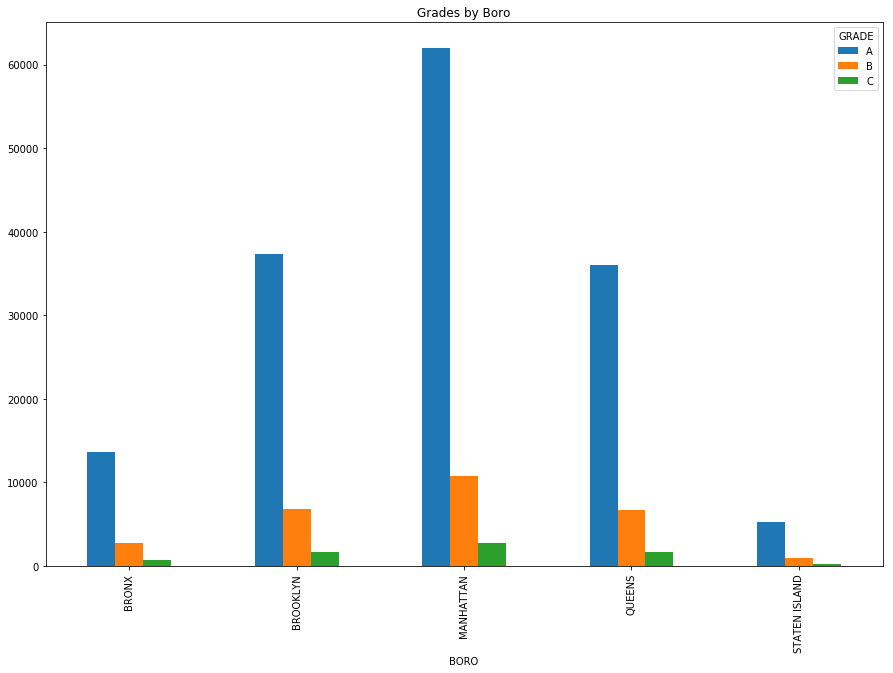

In [7]:
# plot restaurants with A, B, C grade by boro
fig, ax = plt.subplots(figsize=(15,10))
ax.set_title('Grades by Boro')
dfgr[dfgr['GRADE'].apply(lambda x: x in 'ABC')].groupby(['BORO','GRADE'])['CAMIS'].count().unstack().plot(kind='bar', ax=ax);
plt.savefig('grades.png')

### Look at grades by cuisine

In [8]:
# available cuisine descriptions in the dataset
df['CUISINE DESCRIPTION'].unique()

array(['Italian', 'Chinese', 'American', 'Pakistani', 'Japanese',
       'Caribbean', 'Seafood', 'Pizza', 'Indian', 'Soul Food', 'Mexican',
       'Latin (Cuban, Dominican, Puerto Rican, South & Central American)',
       'Bagels/Pretzels', 'Steak', 'Korean', 'Tapas', 'Chinese/Japanese',
       'Hamburgers', 'Vegetarian', 'Turkish', 'African', 'Spanish',
       'CafÃ©/Coffee/Tea', 'Greek', 'Bakery', 'Continental', 'Brazilian',
       'Mediterranean', 'Salads', 'Thai', 'Asian', 'Pizza/Italian',
       'Donuts', 'Delicatessen', 'Jewish/Kosher', 'Sandwiches', 'Russian',
       'Vietnamese/Cambodian/Malaysia', 'Other',
       'Sandwiches/Salads/Mixed Buffet', 'Peruvian', 'Tex-Mex',
       'Bottled beverages, including water, sodas, juices, etc.', 'Irish',
       'French', 'German', 'Ice Cream, Gelato, Yogurt, Ices',
       'Middle Eastern', 'Juice, Smoothies, Fruit Salads', 'Chicken',
       'Australian', 'Bangladeshi', 'Creole', 'Hotdogs', 'Soups',
       'Hotdogs/Pretzels', 'English', 'H

In [9]:
# Shorten the Latin American cuisine description for better visualization
dfgr['CUISINE DESCRIPTION']=dfgr['CUISINE DESCRIPTION'].apply(lambda x: 'Latin' if x=='Latin (Cuban, Dominican, Puerto Rican, South & Central American)' else x)

/home/eli/anaconda3/envs/datachal/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


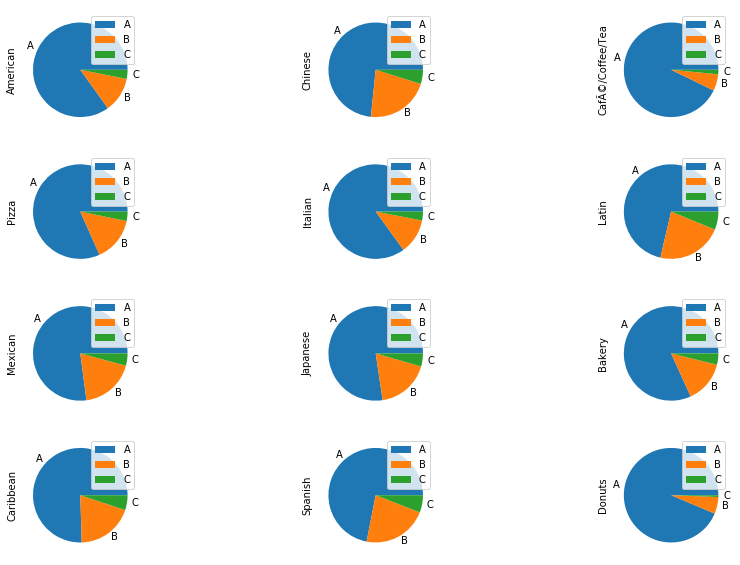

In [10]:
# plot grade ratio by cuisine
fig, ax = plt.subplots(nrows=4,ncols=3,figsize=(15,10))
dfgr[dfgr['GRADE'].apply(lambda x: x in 'ABC')].groupby(['CUISINE DESCRIPTION','GRADE'])['CAMIS'].count().unstack(level=1).nlargest(12,'A').T.plot.pie(subplots=True, ax=ax);
plt.savefig('gradesbycuisine.png')

### Look at the ratio of critical violations by cuisine

In [11]:
# number of critical violations
len(df[df['CRITICAL FLAG']=='Critical'])

220082

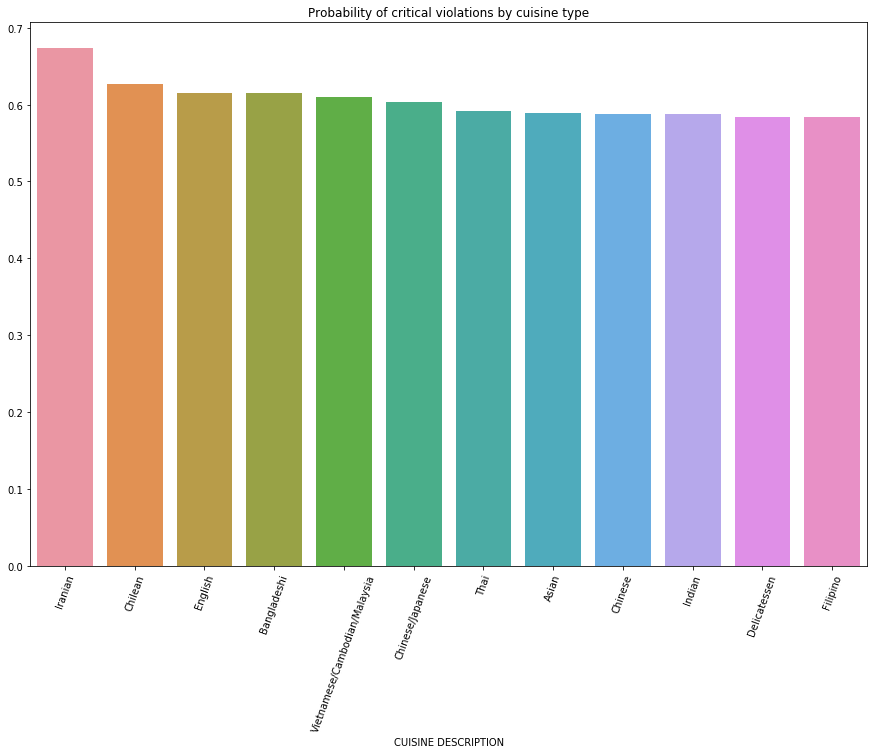

In [12]:
# plot probability of critical violations by cuisine (probability is the number of critical violations normalized by
# the number of inspections)
fig, ax = plt.subplots(figsize=(15,10))
ax.set_title('Probability of critical violations by cuisine type')
plt.xticks(rotation=70)
prob_crit_viol_by_cuisine = df[df['CRITICAL FLAG']=='Critical'].groupby('CUISINE DESCRIPTION')['CAMIS'].count()/df.groupby('CUISINE DESCRIPTION')['CAMIS'].count()
prob_crit_viol_by_cuisine = prob_crit_viol_by_cuisine.dropna().sort_values(ascending=False)
sns.barplot(x=prob_crit_viol_by_cuisine.index[:12],y=prob_crit_viol_by_cuisine.values[:12], ax=ax);
plt.savefig('critprobbycuisine.png')

### Look at inspection scores by month

In [13]:
# turn inpection date into datetime column
df['inspdate']=pd.to_datetime(df['INSPECTION DATE'])

In [14]:
# extract inspection month
df['inspmth']=df['inspdate'].apply(lambda x: x.month)

In [15]:
df['inspseason']=(df['inspmth']%12 + 3)//3

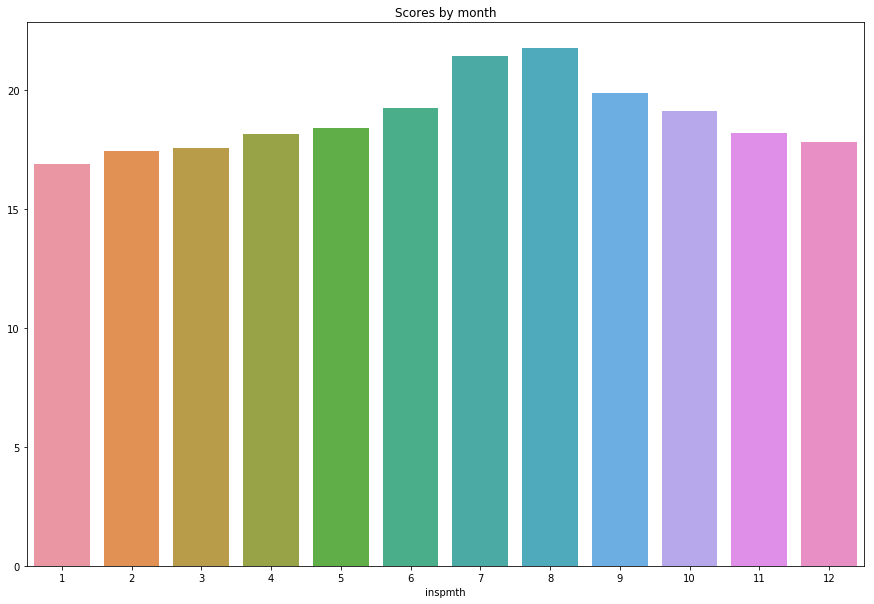

In [16]:
fig, ax = plt.subplots(figsize=(15,10))
ax.set_title('Scores by month')
sns.barplot(x=df.groupby('inspmth')['SCORE'].mean().index,y=df.groupby('inspmth')['SCORE'].mean().values);
plt.savefig('scoremth.png')

### Look at contingency table for categorical variables to select features for the model

In [17]:
## Contingency Table for Cuisine, Grade
table = dfgr[dfgr['GRADE'].apply(lambda x: x in 'ABC')].groupby(['CUISINE DESCRIPTION','GRADE'])['CAMIS'].count().unstack(level=1).dropna().values

In [18]:
len(table)

64

#### Because chi2 test requires at least 5 elements in contingency table, we remove table elements that have less than 6 representatives

In [19]:
len(table[table.min(axis=1)>5,:])

53

In [20]:
from scipy.stats import chi2_contingency
chi2stat,p,dof,ex = chi2_contingency(table[table.min(axis=1)>5,:])

#### Print 'dependent' for dependent variable, 'independent' for independent variable as determined by chi2 test using p<0.05 criterion.

In [21]:
from scipy.stats import chi2
prob=0.95
crit = chi2.ppf(prob,dof)
if np.abs(chi2stat)>crit:
    print('dependent')
else:
    print('independent')

dependent


## Topic Modelling

#### Use topic modeling to classify violation descriptions into three topics. The number of unique descriptions is 94.

In [22]:
len(df['VIOLATION DESCRIPTION'].unique())

94

#### Use nltk to tokenize and lemmatize descriptions before applying Latent Dirichlet Allocation (LDA) algorithm to assign topics

In [23]:
import nltk

In [24]:
flatten = lambda l: [item for sublist in l for item in sublist]
en_stop = set(nltk.corpus.stopwords.words('english'))

In [25]:
def tokenize(text):
    return flatten([nltk.word_tokenize(t) for t in nltk.sent_tokenize(text)])


from nltk.corpus import wordnet as wn
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma
    
def prepare_text_for_lda(text):
    tokens = tokenize(text)
    tokens = [token for token in tokens if len(token) > 3]
    tokens = [token for token in tokens if token not in en_stop]
    tokens = [get_lemma(token) for token in tokens]
    return tokens

In [26]:
df=df.dropna(subset=['VIOLATION DESCRIPTION'])

In [27]:
df['desc']=df['VIOLATION DESCRIPTION'].apply(lambda x: prepare_text_for_lda(x))

#### Because there are only 94 different violation descriptions for 400,000 rows in the table, create a dictionary mapping each description to its tokens which will be then used for LDA

In [28]:
unique_descs=df['VIOLATION DESCRIPTION'].unique()

In [29]:
descdict = {x: prepare_text_for_lda(x) for x in unique_descs}

#### Create a list of tokenized topics and use gensim to form a corpus and fit an LDA model to it

In [31]:
l=[]
for k,v in descdict.items():
    l.append(v)

In [32]:
from gensim import corpora
dictionary = corpora.Dictionary(l)
corpus = [dictionary.doc2bow(text) for text in df['desc'].values]

In [33]:
import gensim
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = 3, id2word=dictionary)
ldamodel.save('ldamodel3.gensim')

In [34]:
# Print the words associated with the topic
topics = ldamodel.print_topics(num_words=10)
for topic in topics:
    print(topic)

(0, '0.095*"food" + 0.038*"item" + 0.037*"hold" + 0.037*"mouse" + 0.035*"facility" + 0.033*"area" + 0.029*"and/or" + 0.028*"Food" + 0.026*"present" + 0.026*"non-food"')
(1, '0.086*"flies" + 0.045*"improperly" + 0.042*"contact" + 0.042*"surface" + 0.040*"Non-food" + 0.027*"and/or" + 0.027*"use" + 0.022*"maintain" + 0.022*"properly" + 0.022*"equipment"')
(2, '0.082*"vermin" + 0.046*"properly" + 0.029*"and/or" + 0.028*"allow" + 0.028*"exist" + 0.028*"conditions" + 0.028*"Facility" + 0.028*"premises" + 0.027*"proof" + 0.027*"Harborage"')


#### Assign topic to a violation description by the most probable topic returned by the lda model. The model returns a list of tuples (topic, probability),  "sorted" is used to return the max probability topic

In [35]:
df['viol_topic']=df['VIOLATION DESCRIPTION'].apply(lambda x: sorted(ldamodel.get_document_topics(dictionary.doc2bow(descdict[x])),key=lambda x:-x[1])[0][0])

#### After assigning the topic, we see the following classes:

In [37]:
df.groupby(['viol_topic'])['CAMIS'].count()

viol_topic
0    136460
1    142999
2    113480
Name: CAMIS, dtype: int64

## Use Zipcode, Grade, Cuisine to build a classifier for violation topics

#### Make sure we remove rows with missing data needed for the model

In [38]:
dftm = df.dropna(subset=['GRADE','ZIPCODE','CUISINE DESCRIPTION'])

#### This removes about 50% of the data but we still have almost 200,000 records

In [39]:
len(dftm)

194260

#### Remove zipcodes and cuisines that are not well-represented in the data

In [40]:
dftm.drop_duplicates(subset=['CAMIS']).groupby(['ZIPCODE'])['CAMIS'].count().describe()

count    230.000000
mean     109.843478
std      124.061162
min        1.000000
25%       22.000000
50%       79.000000
75%      152.500000
max      675.000000
Name: CAMIS, dtype: float64

In [41]:
dftm.drop_duplicates(subset=['CAMIS']).groupby(['CUISINE DESCRIPTION'])['CAMIS'].count().describe()

count      84.000000
mean      300.761905
std       740.267757
min         2.000000
25%        17.500000
50%        69.000000
75%       317.500000
max      6053.000000
Name: CAMIS, dtype: float64

#### Remove outliers: namely, zipcodes and cuisines that have less than 16 restaurants. The bottom quartile for both zipcodes and cuisines is below about 20.

In [42]:
zipindex=dftm.drop_duplicates(subset=['CAMIS']).groupby(['ZIPCODE'])['CAMIS'].count()[dftm.drop_duplicates(subset=['CAMIS']).groupby(['ZIPCODE'])['CAMIS'].count()<16].index.values

In [43]:
cuisindex=dftm.drop_duplicates(subset=['CAMIS']).groupby(['CUISINE DESCRIPTION'])['CAMIS'].count()[dftm.drop_duplicates(subset=['CAMIS']).groupby(['CUISINE DESCRIPTION'])['CAMIS'].count()<16].index.values

In [44]:
##remove outliers
dftm=dftm[~dftm.ZIPCODE.isin(zipindex)]
dftm=dftm[~dftm['CUISINE DESCRIPTION'].isin(cuisindex)]
len(dftm)

192431

In [45]:
##filter for grade
dftm=dftm[dftm['GRADE'].isin(['A','B','C'])]

#### The selected features are all categorical, use one-hot encoding to transform them to dummy variables

In [46]:
from sklearn import preprocessing
enc = preprocessing.OneHotEncoder()

In [47]:
X=dftm[['GRADE','ZIPCODE','CUISINE DESCRIPTION']].values

In [48]:
enc.fit(X)

OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='error',
       n_values=None, sparse=True)

In [49]:
X=enc.transform(X)

#### Use train_test_split to split the data into training st and test set to validate the model performance

In [50]:
from sklearn.model_selection import train_test_split

In [57]:
X_tr, X_test, y_tr, y_test = train_test_split(X, dftm['viol_topic'].values, test_size=0.2)

#### Training set has 186K+ rows

In [58]:
dftm['viol_topic'].values.shape

(186582,)

#### Fit random forest classifier

In [59]:
from sklearn.ensemble import RandomForestClassifier

In [60]:
rf=RandomForestClassifier()
rf.fit(X_tr,y_tr)

/home/eli/anaconda3/envs/datachal/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [61]:
rf.score(X_tr,y_tr) # accuracy score on training data

0.47335276186647907

In [62]:
rf.score(X_test,y_test) # accuracy score on test data

0.40930407053085727

#### Derive feature importances from our model, group features into classes: grade, zipcode, cuisine. Plot the obtained feature importances.

In [63]:
fimp = {"grade": [rf.feature_importances_[:3].sum()], "zip" : [rf.feature_importances_[3:183].sum()], "cuisine" :[rf.feature_importances_[184:].sum()]}

In [64]:
fimp=pd.DataFrame.from_dict(fimp)

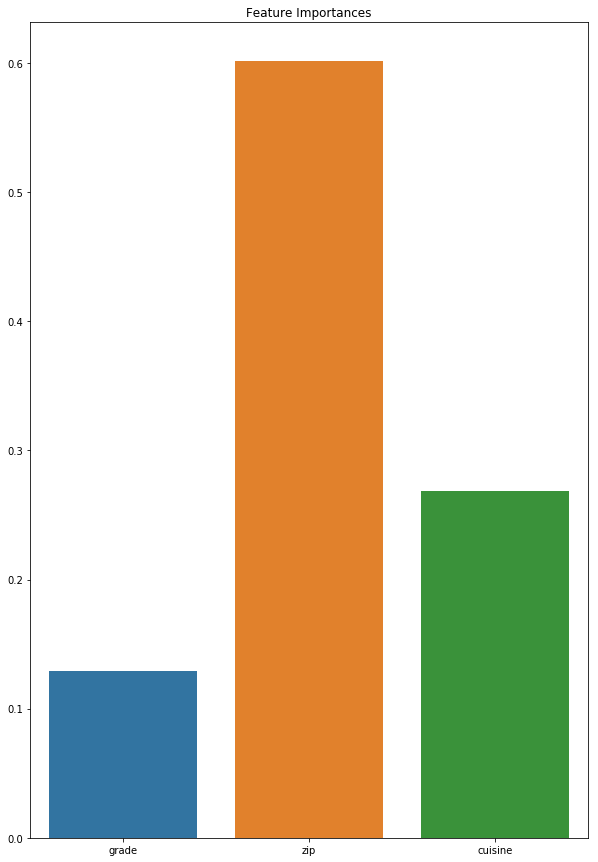

In [65]:
fig,ax=plt.subplots(figsize=(10,15))
ax.set_title('Feature Importances')
sns.barplot(x=fimp.columns,y=fimp.values[0]);
plt.savefig('featureimp.png')

#### Evaluate the performance of the random forest classifier on each model topic

In [66]:
from sklearn.metrics import classification_report
print(classification_report(y_test, rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.34      0.20      0.26     11432
           1       0.44      0.77      0.56     15823
           2       0.24      0.08      0.12     10062

   micro avg       0.41      0.41      0.41     37317
   macro avg       0.34      0.35      0.31     37317
weighted avg       0.36      0.41      0.35     37317

